In [1]:
import numpy as np
import tensorflow as tf

import os

from tensorflow.keras.models import load_model
import cv2

from face_mask_detection import utils
from face_mask_detection import model_utils

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
import importlib

In [3]:
importlib.reload(model_utils)

<module 'face_mask_detection.model_utils' from 'C:\\Users\\Wojtek\\Documents\\Projects\\face-mask-detection\\face_mask_detection\\model_utils.py'>

In [8]:
facemask_classifier = load_model(r'models/facemask-classifier')

In [6]:
face_detector = model_utils.load_caffe_model(r'models/face-detector')

In [4]:
test_image = r'dataset/test_detection/4.jpg'
image = cv2.imread(test_image)

In [9]:
det_class_results = model_utils.check_face_masks(image, face_detector, facemask_classifier)

In [16]:
def visualize_detection_classification_results(image, detection_classification_results):
    
    for result in detection_classification_results:
        
        label = result['class']
    
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, result['probability'])

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (result['start_x'], result['start_y'] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (result['start_x'], result['start_y']), (result['end_x'], result['end_y']), color, 2)

    return image


In [12]:
import matplotlib.pyplot as plt

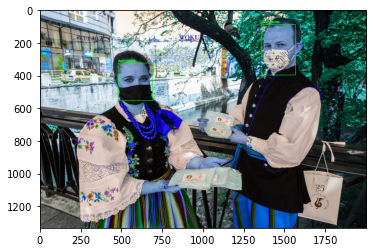

In [13]:
plt.imshow(image)

In [10]:
image = utils.visualize_detection_classification_results(image, det_class_results)

In [3]:
input_shape = (224, 224, 3)

test_dataset_path = r'dataset\test_classification'
test_data, test_labels = utils.prepare_dataset(test_dataset_path, input_shape[:-1], {'with_mask': 0, 'without_mask': 1})
test_labels_one_hot = utils.to_one_hot(test_labels)

test_dataset = tf.data.Dataset.from_tensors(test_data)
numpy_list = [item.numpy() for item in test_data]
test_dataset_numpy = np.asarray(numpy_list)

predictions = facemask_classifier.evaluate(test_dataset_numpy, test_labels_one_hot)

2/2 [==============================] - 0s 138ms/step - loss: 1.4275e-05 - accuracy: 1.0000


In [4]:
def load_caffe_model(caffe_model_path):
    prototxt_file = [file for file in os.listdir(caffe_model_path) if file.endswith('.prototxt')][0]
    caffe_model_file = [file for file in os.listdir(caffe_model_path) if file.endswith('.caffemodel')][0]
    model = cv2.dnn.readNet(os.path.join(caffe_model_path, prototxt_file), os.path.join(caffe_model_path, caffe_model_file))
    return model

In [5]:
face_detector = load_caffe_model(r'models/face-detector')

In [6]:
face_detector

<dnn_Net 000001A1440B8950>

In [7]:
test_image = r'dataset/test_detection/5.jpg'

In [8]:
image = cv2.imread(test_image)
(h, w) = image.shape[:2]

In [9]:
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

face_detector.setInput(blob)
detections = face_detector.forward()

In [20]:
detections

array([[[[0.        , 1.        , 0.82227284, ..., 0.06675304,
          0.7818571 , 0.29796505],
         [0.        , 1.        , 0.77985734, ..., 0.24366567,
          0.34461167, 0.41631398],
         [0.        , 1.        , 0.16484074, ..., 0.11992747,
          0.7659547 , 0.24657166],
         ...,
         [0.        , 1.        , 0.11640719, ..., 0.9277075 ,
          0.29969054, 0.96700865],
         [0.        , 1.        , 0.11630629, ..., 0.1505827 ,
          0.6124235 , 0.18558711],
         [0.        , 1.        , 0.11626296, ..., 0.22086473,
          0.56655204, 0.26505017]]]], dtype=float32)

In [10]:
def detect_faces(image, face_detector):
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_detector.setInput(blob)
    detections = face_detector.forward()
    return detections

In [16]:
def check_face_masks(image, face_detector, facemask_classifier):
    
    
    detections = detect_faces(image, face_detector)
    
    for i in range(0, detections.shape[2]):
    
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            detection = detections[0, 0, i, 3:7]
            face, bounding_box_cords = extract_face(image, detection)
        
            
            (mask, withoutMask) = facemask_classifier.predict(face)[0]
            
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(image, label, (bounding_box_cords['start_x'], bounding_box_cords['start_y'] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (bounding_box_cords['start_x'], bounding_box_cords['start_y']), (bounding_box_cords['end_x'], bounding_box_cords['end_y']), color, 2)
            
            cv2.imshow("Output", image)
            cv2.waitKey(0)

In [17]:
def extract_face(image, detection):
    (h, w) = image.shape[:2]
    box = detection * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    
    (start_x, start_y) = (max(0, startX), max(0, startY))
    (end_x, end_y) = (min(w - 1, endX), min(h - 1, endY))
    
    bounding_box_cords = {
        'start_x' : start_x,
        'start_y' : start_y,
        'end_x' : end_x,
        'end_y' : end_y
    }
    
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)
    
    return face, bounding_box_cords

In [18]:
test_image = r'dataset/test_detection/5.jpg'
image = cv2.imread(test_image)

check_face_masks(image, face_detector, facemask_classifier)

In [10]:
for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # pass the face through the model to determine if the face
            # has a mask or not
            (mask, withoutMask) = facemask_classifier.predict(face)[0]

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

In [11]:
cv2.imshow("Output", image)
cv2.waitKey(0)

0